# Tutorial pysm

The main interface to PySM is the pysm3.Sky class, the simplest way is to specify the required resolution as HEALPix parameter and the requested models as a list of strings, for example the simplest models for galactic dust and synchrotron ["d1", "s1"]


--- 

Tutoriales en:

https://pysm3.readthedocs.io/en/latest/#best-practices-for-model-execution


### Getting started

In [1]:
import pysm3
import pysm3.units as u
import healpy as hp
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"])


PySM initializes the requested component objects (generally load the input templates maps with astropy.utils.data and cache them locally in ~/.astropy) and stores them in the components attribute (a list):



In [4]:
sky.components


PySM 3 uses astropy.units: http://docs.astropy.org/en/stable/units/ each input needs to have a unit attached to it, the unit just needs to be compatible, e.g. you can use either u.GHz or u.MHz.

In [5]:
map_100GHz = sky.get_emission(100 * u.GHz)


The output of the get_emission method is a 2D numpy array in the usual healpy convention, [I,Q,U], the polarization convention used, as customary for CMB datasets, is COSMO instead of IAU: https://lambda.gsfc.nasa.gov/product/about/pol_convention.html. The unit by default is \mu K_{RJ} 

In [6]:
map_100GHz[0, :3]


<Quantity [1.8686613, 1.9287539, 2.237162 ] uK_RJ>

Optionally convert to another unit using astropy.units



In [7]:
map_100GHz = map_100GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(100*u.GHz))


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

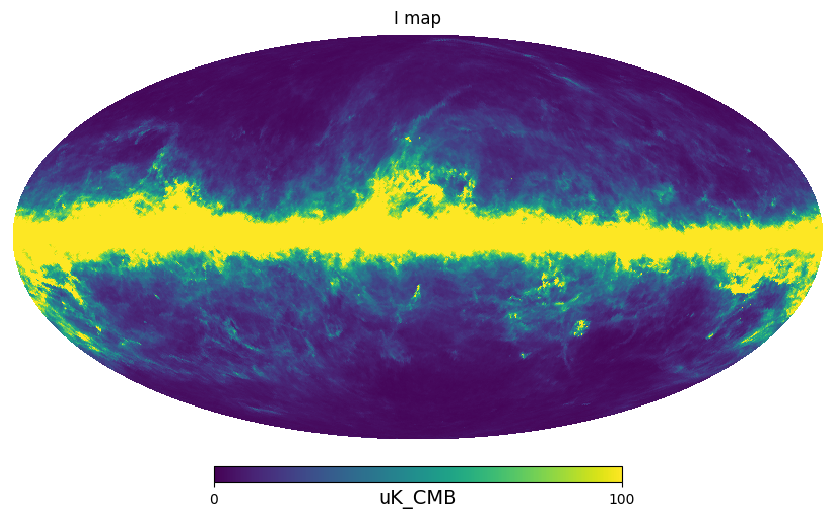

In [9]:
hp.mollview(map_100GHz[0], min=0, max=1e2, title="I map", unit=map_100GHz.unit)


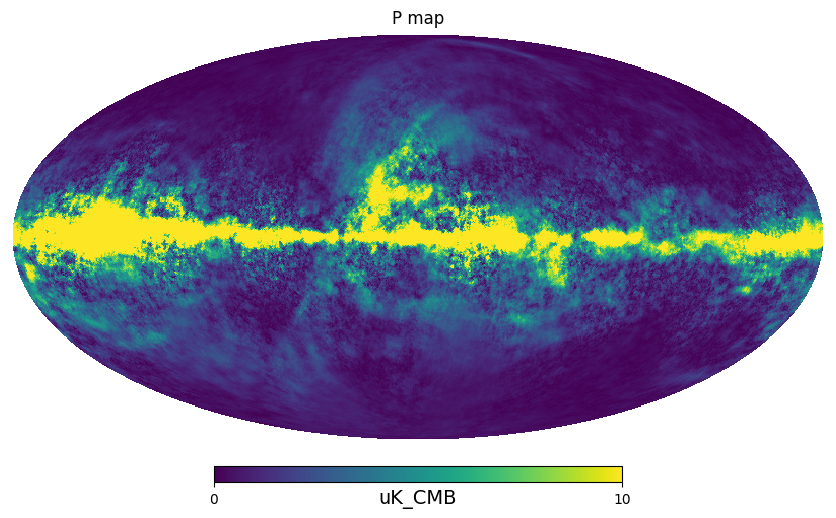

In [10]:
hp.mollview(np.sqrt(map_100GHz[1]**2 + map_100GHz[2]**2), title="P map", min=0, max=1e1, unit=map_100GHz.unit)


### Model data

---
In this tutorial we will inspect how the different models are defined in pysm3 and how you can inspect the templates.

The notebook cell with all import statements is hidden, see the “Getting started” tutorial.



In [11]:
sky = pysm3.Sky(nside=128, preset_strings=["d1"])
sky.components[0].__class__
pysm3.models.dust.ModifiedBlackBody
print(pysm3.models.dust.ModifiedBlackBody.__init__.__doc__)
     

 This function initializes the modified black body model.

        The initialization of this model consists of reading in emission
        templates from file, reading in spectral parameter maps from
        file.

        Parameters
        ----------
        map_I, map_Q, map_U: `pathlib.Path` object
            Paths to the maps to be used as I, Q, U templates.
            If has_polarization is True and map_Q is None, assumes map_I is IQU
        unit_* : string or Unit
            Unit string or Unit object for all input FITS maps, if None, the input file
            should have a unit defined in the FITS header.
        freq_ref_I, freq_ref_P: Quantity or string
            Reference frequencies at which the intensity and polarization
            templates are defined. They should be a astropy Quantity object
            or a string (e.g. "1500 MHz") compatible with GHz.
        map_mbb_index: `pathlib.Path` object or scalar value
            Path to the map to be used as the po

Details of a model are defined in presets.cfg at https://github.com/galsci/pysm/blob/main/src/pysm3/data/presets.cfg, for example:

The filenames refer to another Github repository: https://github.com/galsci/pysm-data/tree/master/pysm_2

pysm3 3 automatically downloads and caches those data using the astropy.utils.data facilities. Therefore the first time you use d1 it downloads all the templates and caches them in your home folder, next will load from there.

### Inspect model inputs

---

Model templates are stored as attributes of the model class and can be inspected and even modified in place.

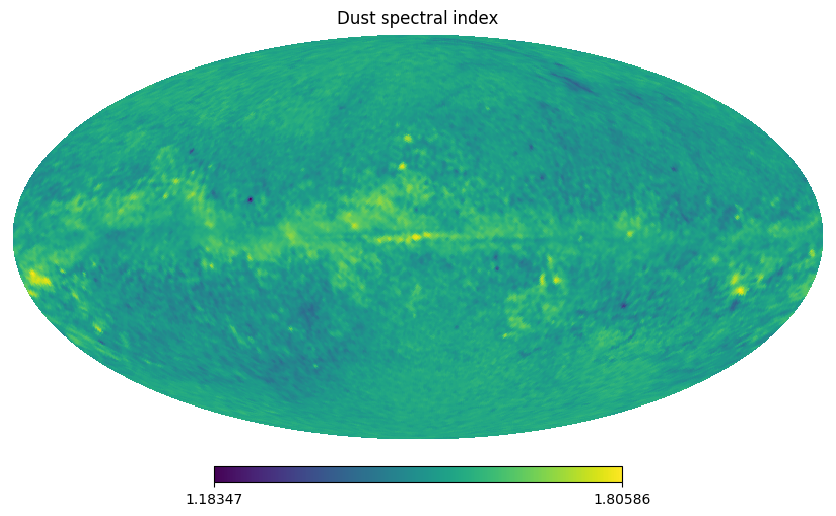

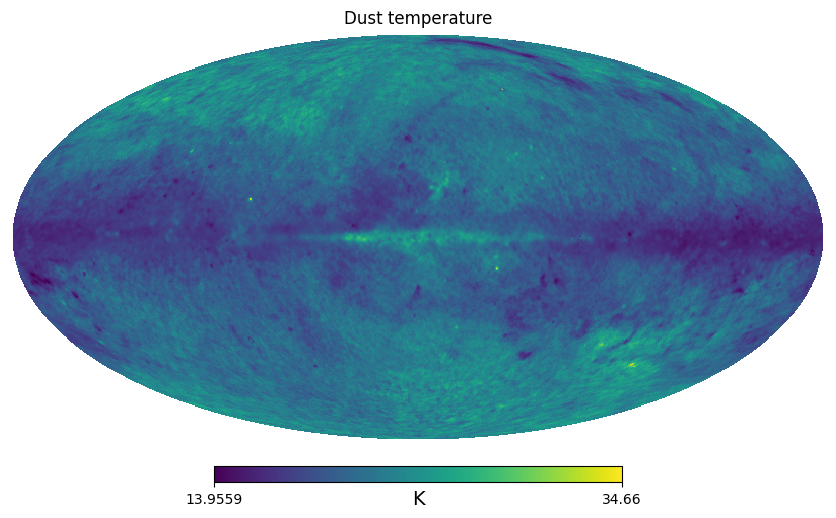

In [12]:
dust = sky.components[0]
hp.mollview(dust.mbb_index, title="Dust spectral index", unit=dust.mbb_index.unit)

hp.mollview(dust.mbb_temperature, title="Dust temperature", unit=dust.mbb_temperature.unit)


### Bandpass integration

---

The get_emission method implemented by any subclass of Model, including Sky, allows a numpy array of frequencies instead of a single frequency value to define a tophat bandpass and optionally a weights array of the same length to define a custom weight. PySM normalizes the weights array to unit integral then generates the emission at each of the specified frequencies, it multiplies it by the corresponding weight, and integrates them with the Trapezoidal rule. Instead of having generating all the maps as PySM 2, PySM 3 keeps in memory just 1 array for the output map and then creates the maps at a specific frequency one at a time and accomulates it properly into the output array.

Integration and weighting is always performed in spectral radiance units Jy/sr 
 and the weights are assumed to be given in those units, this is the same convention used by Planck HFI. For example if input templates are in K_[RJ}
 and the output is requested in K_{CMB}
:

Each component Model loads the inputs from disk in K_{RJ}

Evaluates the emission of the component at each of the frequency point 

It weights them with bandpass weights that also include the transformation to spectral radiance units (this is performed by utils.normalize_bandpass)

Emission is accumulated into the output map and integrated in Spectral Radiance units

The integrated map is then converted back to 
 (thanks to the common factor applied also by utils.normalize_bandpass). The output of each Model object is in K_{RJ}  for compatibility with PySM 2.

Finally the Sky object sums all the components and converts the output from 
 to the desired output unit, e.g. K_{CMB} , using a factor computed by utils.bandpass_unit_conversion.

In [13]:
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"])

In [14]:
map_100GHz_delta = sky.get_emission(100 * u.GHz)

In [15]:
bandpass_frequencies = np.linspace(95, 105, 11) * u.GHz

In [16]:
bandpass_frequencies

<Quantity [ 95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
           105.] GHz>

In [17]:
map_100GHz_tophat = sky.get_emission(bandpass_frequencies)

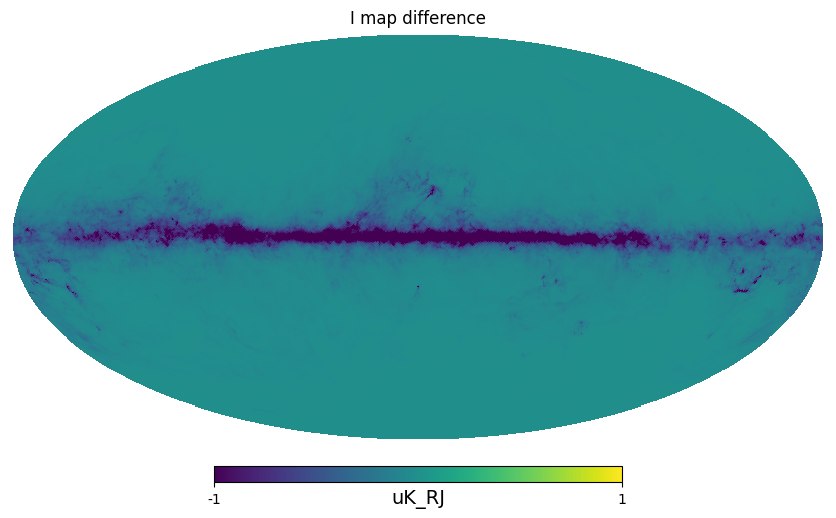

In [18]:
hp.mollview(map_100GHz_delta[0] - map_100GHz_tophat[0], min=-1, max=1, title="I map difference", unit=map_100GHz_tophat.unit)


In [19]:
bandpass_weights = np.array([2,3,5,9,11,11.5,11,9,5,3,2])

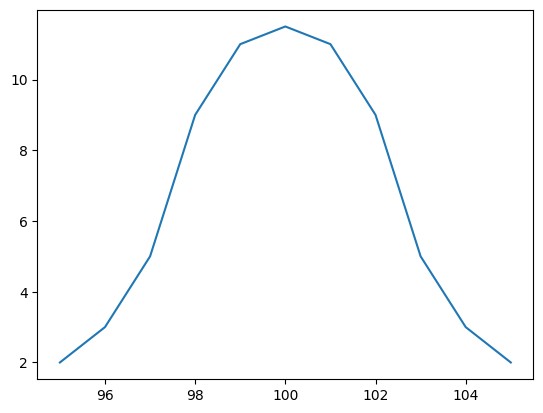

In [20]:
plt.plot(bandpass_frequencies,bandpass_weights);

In [21]:
map_100GHz_bandpass = sky.get_emission(bandpass_frequencies, bandpass_weights)

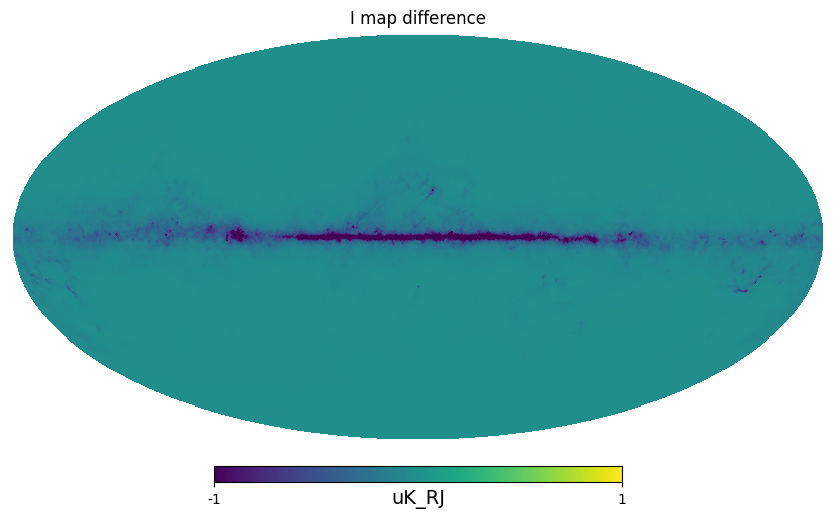

In [22]:
hp.mollview(map_100GHz_bandpass[0] - map_100GHz_tophat[0], min=-1, max=1, title="I map difference", unit=map_100GHz_tophat.unit)

### Smoothing and coordinate transformation

---

Smoothing and coordinate transforms are combined because they are both performed in spherical harmonics space, so we can have a single transform to and from a_{lm}.

Currently they are implemented as an indepent function pysm3.apply_smoothing_and_coord_transform which takes an input map and returns another map either smoothed or coordinate-transformed or both. Usually it operates on maps created with pysm3.Sky.get_emission but it would work even with other inputs.

In [23]:
sky = pysm3.Sky(nside=128, preset_strings=["d1", "s1"])

In [24]:
map_100GHz = sky.get_emission(100 * u.GHz)

In [25]:
2*u.deg


<Quantity 2. deg>

In [26]:
pysm3.apply_smoothing_and_coord_transform?

map_100GHz_smoothed = pysm3.apply_smoothing_and_coord_transform(map_100GHz, fwhm=2*u.deg)



Signature:
pysm3.apply_smoothing_and_coord_transform(
    input_map,
    fwhm=None,
    rot=None,
    lmax=None,
    output_nside=None,
    output_car_resol=None,
    return_healpix=True,
    return_car=False,
    input_alm=False,
    map2alm_lsq_maxiter=10,
    map_dist=None,
)
Docstring:
Apply smoothing and coordinate rotation to an input map

it applies the `healpy.smoothing` Gaussian smoothing kernel if `map_dist`
is None, otherwise applies distributed smoothing with `libsharp`.
In the distributed case, no rotation is supported.

Parameters
----------
input_map : ndarray
    Input map, of shape `(3, npix)`
    This is assumed to have no beam at this point, as the
    simulated small scale template on which the simulations are based
    have no beam.
fwhm : astropy.units.Quantity
    Full width at half-maximum, defining the
    Gaussian kernels to be applied.
rot: hp.Rotator
    Apply a coordinate rotation give a healpy `Rotator`, e.g. if the
    inputs are in Galactic, `hp.Rotator(

In [27]:
def plot_map(m):
    """Utility function to plot Mollweide view of a map"""
    hp.mollview(m[0], min=0, max=1e2, title="I map", unit=m.unit)

In [28]:
#map_100GHz_smoothed = pysm3.apply_smoothing_and_coord_transform(map_100GHz, fwhm=2*u.deg)


map_100GHz_smoothed = pysm3.apply_smoothing_and_coord_transform(map_100GHz, 
                                                                fwhm=2*u.deg, 
                                                                output_nside=128)


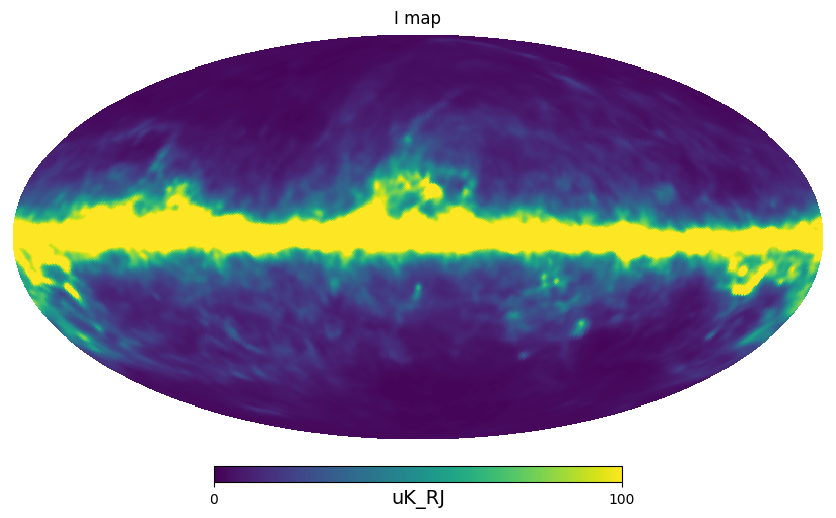

In [30]:
plot_map(map_100GHz_smoothed)

In [31]:
map_100GHz_rotated = pysm3.apply_smoothing_and_coord_transform(map_100GHz, rot=hp.Rotator(coord="GE"))

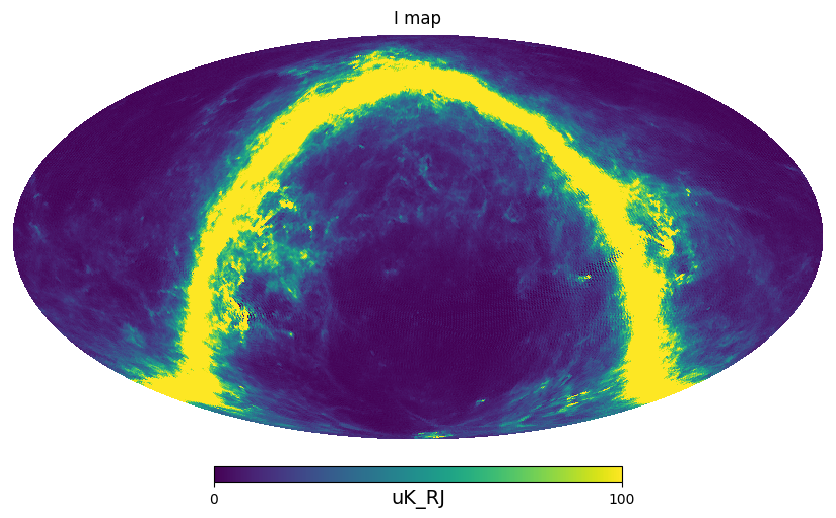

In [32]:
plot_map(map_100GHz_rotated)

In [33]:
map_100GHz_smoothed_rotated = pysm3.apply_smoothing_and_coord_transform(map_100GHz, rot=hp.Rotator(coord="GE"), fwhm=2*u.deg)

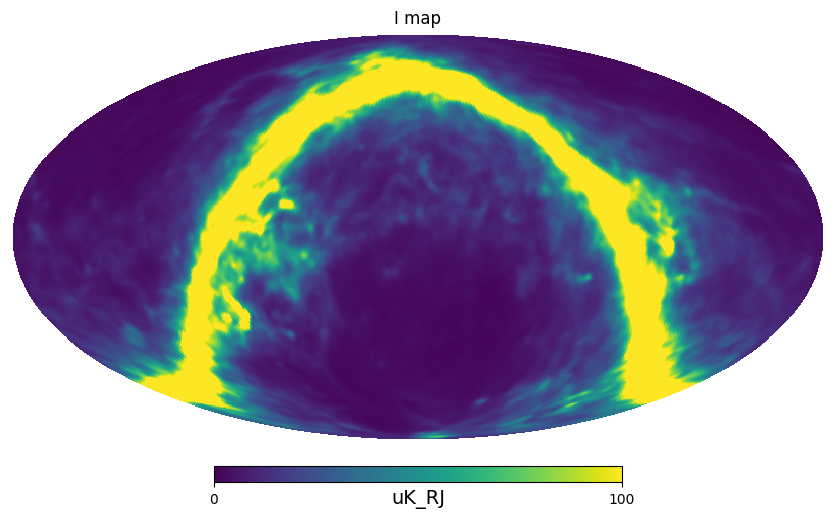

In [34]:
plot_map(map_100GHz_smoothed_rotated)

### Customize PySM models

---

There are 3 straightforward ways to customize PySM models.

First we can still keep the same algorithms used to generate the components and just provide different templates/paramers, we can achieve this either using configuration files or, for more flexibility, work directly with the component Python object.

Instead if we need to implement different algorithms, we need to implement a subclass of pysm3.Mode

Use a configuration file
The PySM models are implemented as classes and are then configured with input parameters in `presets.cfg <https://github.com/galsci/pysm/blob/main/pysm3/data/presets.cfg>`__, the same facilities used to load that configuration file and create the component object can be leverage by creating our own cfg file, for example here we are using a scalar value for map_mbb_index instead of using the template map provided in the d1 model. But we could as well replace the maps with our own custom maps.

The %%file magic creates a file with the content of the cell


Overwriting mydust.cfg

In [35]:
sky_mydust = pysm3.Sky(nside=128, component_config="mydust.cfg")

In [36]:
sky_d1 = pysm3.Sky(nside=128, preset_strings=["d1"])

In [37]:
map_100GHz_mydust = sky_mydust.get_emission(100 * u.GHz)

In [38]:
map_100GHz_d1 = sky_d1.get_emission(100 * u.GHz)

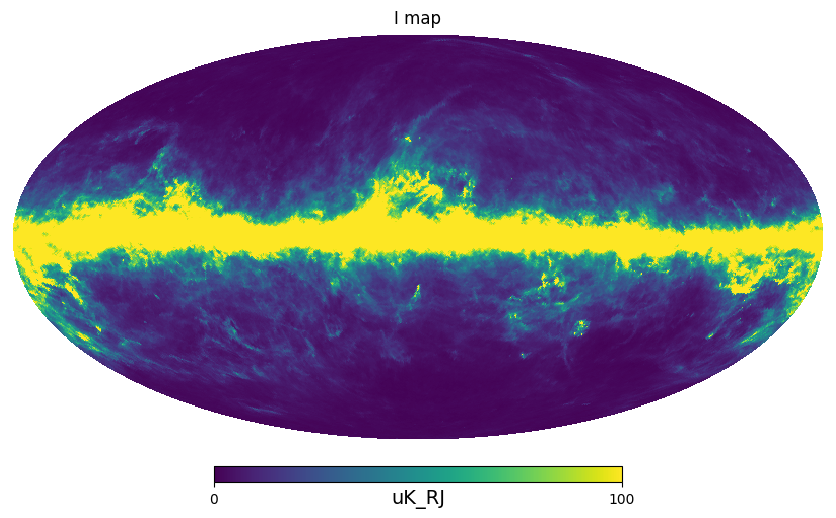

In [39]:
hp.mollview(map_100GHz_mydust[0], min=0, max=100, title="I map", unit=map_100GHz_d1.unit)

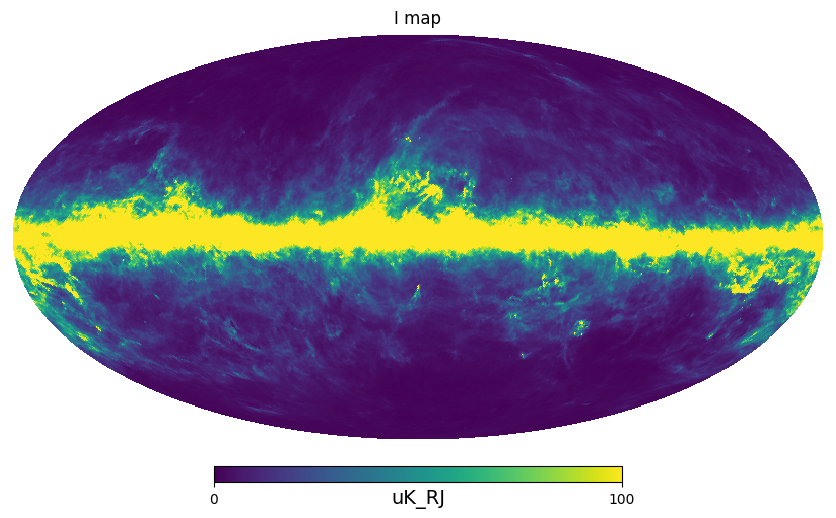

In [40]:
hp.mollview(map_100GHz_d1[0], min=0, max=100, title="I map", unit=map_100GHz_d1.unit)

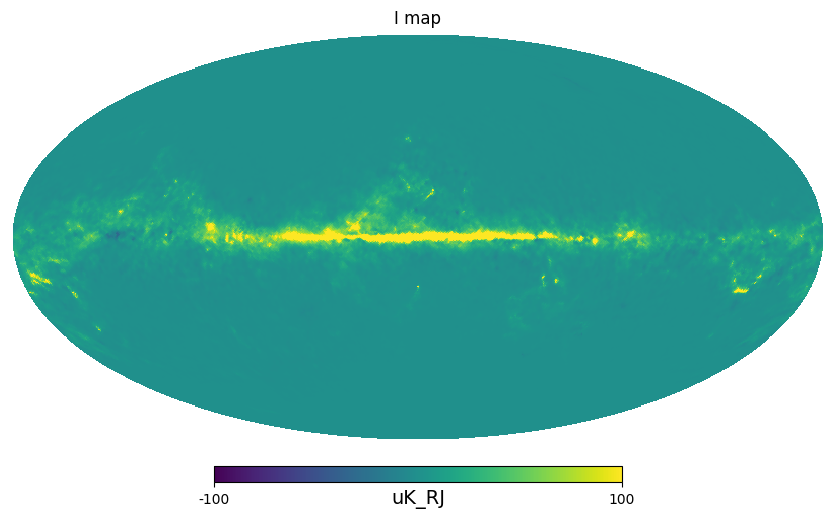

In [41]:
hp.mollview(map_100GHz_mydust[0] - map_100GHz_d1[0], min=-100, max=100, title="I map", unit=map_100GHz_d1.unit)

### Work with the component class
---
We have more flexibility if we use the component class itself, we can create an instance and we can provide different input parameters and that is equivalent of using a configuration file.

But we can also create the class and then modify in place the class attributes, see an example below:

In [42]:
dust = pysm3.ModifiedBlackBody(
    nside = 128,
    map_I = "pysm_2/dust_t_new.fits",
    map_Q = "pysm_2/dust_q_new.fits",
    map_U = "pysm_2/dust_u_new.fits",
    unit_I = "uK_RJ",
    unit_Q = "uK_RJ",
    unit_U = "uK_RJ",
    map_mbb_index = "pysm_2/dust_beta.fits",
    map_mbb_temperature = "pysm_2/dust_temp.fits",
    unit_mbb_temperature = "K",
    freq_ref_I = "545 GHz",
    freq_ref_P = "353 GHz"
)

In [43]:
dust.mbb_temperature *= .8

In [44]:
map_100GHz_mydust = dust.get_emission(100 * u.GHz)

In [45]:
sky_d1 = pysm3.Sky(nside = 128, preset_strings=["d1"])

In [46]:
map_100GHz_d1 = sky_d1.get_emission(100 * u.GHz)

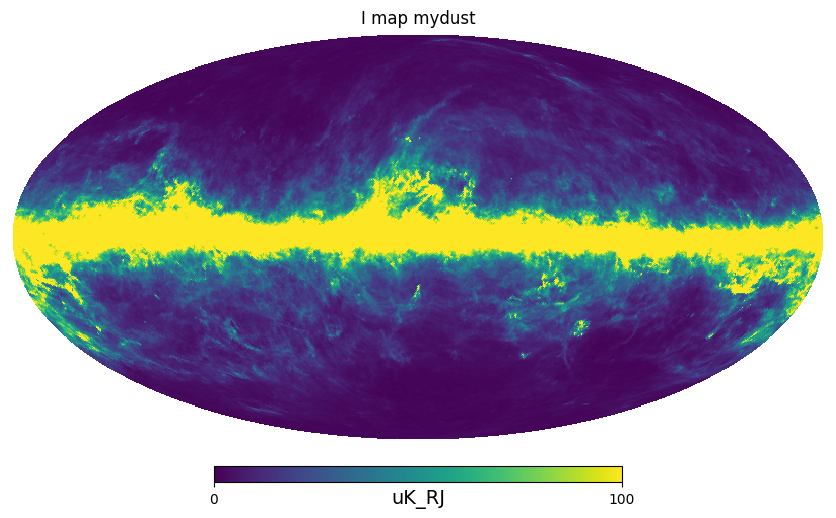

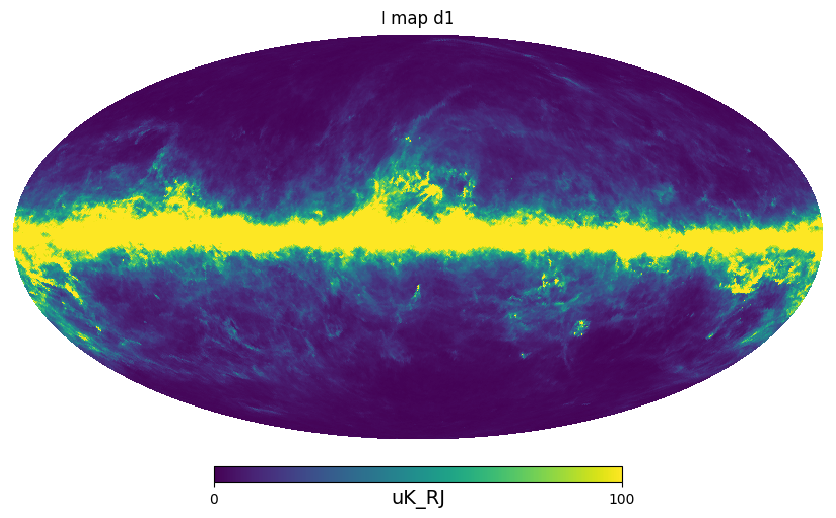

In [47]:
hp.mollview(map_100GHz_mydust[0], min=0, max=100, title="I map mydust", unit=map_100GHz_d1.unit)
hp.mollview(map_100GHz_d1[0], min=0, max=100, title="I map d1", unit=map_100GHz_d1.unit)

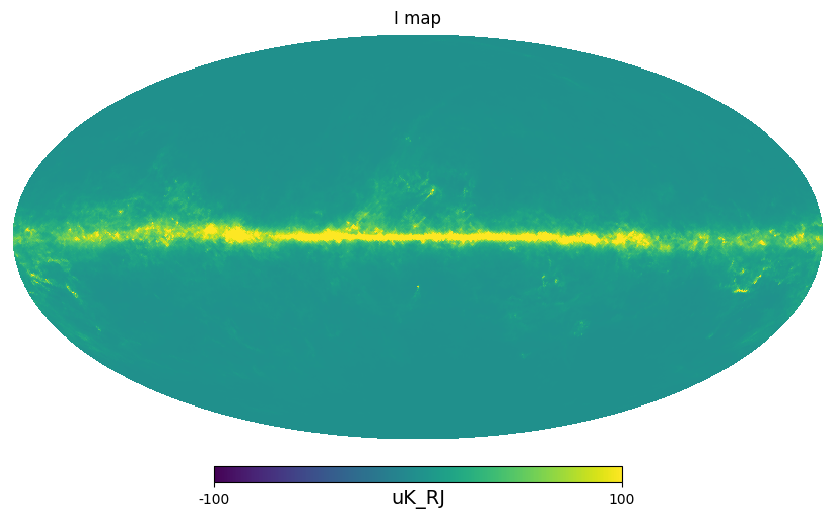

In [48]:
hp.mollview(map_100GHz_mydust[0] - map_100GHz_d1[0], min=-100, max=100, title="I map", unit=map_100GHz_d1.unit)

### Implement a subclass of pysm3.Model

---

In order to implement your own model, subclass pysm3.Model and implement the get_emission method which gets an array of frequency freqs and a bandpass weights and performs the computation and bandpass integration and returns the output in uK_RJ.

If we want to reuse some of the algorithms implemented in one of the PySM classes, it is possible to directly subclass one of those instead of starting from pysm3.Model.

In [49]:
class Monopole(pysm3.Model):
    def __init__(self, nside, value, map_dist=None):
        super().__init__(nside=nside, map_dist=map_dist)
        self.value = value << u.uK_RJ
    def get_emission(self, freqs, weights=None):
        return np.ones((3, hp.nside2npix(self.nside))) * self.value
        

In [50]:
monopole = Monopole(nside=128, value=1*u.mK_RJ)

In [51]:
monopole.get_emission(10 * u.GHz)

<Quantity [[1000., 1000., 1000., ..., 1000., 1000., 1000.],
           [1000., 1000., 1000., ..., 1000., 1000., 1000.],
           [1000., 1000., 1000., ..., 1000., 1000., 1000.]] uK_RJ>

In [52]:
sky = pysm3.Sky(nside=128, preset_strings=["d1"], component_objects=[monopole])

In [53]:
sky.get_emission(100 * u.GHz)[0, :3]

<Quantity [1001.28953111, 1001.34435272, 1001.55604219] uK_RJ>

For performance better use numba to make use of all cores on the machine and execute at compiled code speed, for example:

https://github.com/galsci/pysm/blob/main/pysm3/models/power_law.py